## Hyperdrive Exploration Simulation
This notebook is to explore the base functionality of Hyperdrive

For details on the simulation framework, please see our <a href="https://elfpy.element.fi/"> simulation documentation</a>

### Install repo requirements & import packages

In [6]:
# test: skip-cell
try: # install dependencies only if running on google colab
    import google.colab # check if running in colab
    !pip install -r https://raw.githubusercontent.com/element-fi/elf-simulations/main/requirements-3.8.txt 
    !pip install git+https://github.com/element-fi/elf-simulations.git
except:
    print("running locally & trusting that you have the dependencies installed")

running locally & trusting that you have the dependencies installed


In [7]:
from __future__ import annotations

import numpy as np
from numpy.random._generator import Generator
import matplotlib.ticker as ticker

from elfpy import WEI
from elfpy.agents.agent import Agent
from elfpy.markets.hyperdrive import Market, MarketAction, MarketActionType
from elfpy.utils import sim_utils
import elfpy.utils.outputs as output_utils
import elfpy.utils.post_processing as post_processing
from elfpy.simulators import Config

### Setup experiment parameters

In [8]:
config = Config()

# General config parameters
config.title = "Hyperdrive Core Features"
config.pricing_model_name = "Hyperdrive" # can be yieldspace or hyperdrive

config.num_trading_days = 20 # Number of simulated trading days
config.num_blocks_per_day = 5 # Blocks in a given day (7200 means ~12 sec per block)
config.num_position_days = 10 # How long a token reaches maturity

config.trade_fee_percent = 0.05 # fee percent collected on trades
config.redemption_fee_percent = 0.05 # fee collected on the spread of the flat portion

config.target_fixed_apr = 0.01 # target fixed APR of the initial market after the LP
config.target_liquidity = 500_000_000 # target total liquidity of the initial market, before any trades

config.log_level = output_utils.text_to_log_level("INFO") # Logging level, should be in ["DEBUG", "INFO", "WARNING"]
config.log_filename = "./hyperdrive_exploration.log" # Output filename for logging

config.shuffle_users = True

# Notebook specific parameters
# TBD

# Define the vault apr
vault_apr = np.array([0.01] * config.num_trading_days)

#vault_apr[config.num_trading_days//2:] = 0.05
config.variable_apr = vault_apr.tolist()
config.freeze()

fig_size = (5, 5)

### Setup agents

In [9]:
class ShortAgent(Agent):
    """Opens Basic Short"""
    def action(self, market: Market):
        """implement user strategy"""
        return []

In [10]:
class LongAgent(Agent):
    """Opens Basic Long"""
    def action(self, market: Market):
        """implement user strategy"""
        return []

In [11]:
class LPAgent(Agent):
    """Adds a large LP"""
    def action(self, market: Market):
        """implement user strategy"""
        if self.wallet.lp_tokens > 0: # has already opened the lp
            action_list = []
        else:
            action_list = [
                self.create_agent_action(
                    action_type=MarketActionType.ADD_LIQUIDITY, trade_amount=self.budget
                ),
            ]
        return action_list

### Instantiate Example Agents

In [14]:

def get_example_agents(rng: Generator, num_shorts: int, num_longs: int, existing_agents: int = 0) -> list[Agent]:
    """Instantiate a set of custom agents"""
    agents = []
    for address in range(existing_agents, existing_agents + num_shorts):
        agent = ShortAgent(
            wallet_address=address,
            budget=5_000,
        )
        agent.log_status_report()
        agents += [agent]
    existing_agents += len(agents)
    return agents

### Setup simulation objects

In [15]:
# define root logging parameters
output_utils.setup_logging(log_filename=config.log_filename, log_level=config.log_level)

# get an instantiated simulator object
simulator = sim_utils.get_simulator(config)

### Run the simulation

In [16]:
# add the random agents
trading_agents = get_example_agents(
    rng=simulator.rng,
    num_shorts=1,
    num_longs=0,
    existing_agents=len(simulator.agents)
)
simulator.add_agents(trading_agents)
print(f"Simulator has {len(simulator.agents)} agents")

# run the simulation
simulator.run_simulation()

Simulator has 2 agents


In [20]:
# print(simulator.get_simulation_state_string())
print(simulator.market.__dict__)

# convert simulation state to a pandas dataframe
trades = post_processing.compute_derived_variables(simulator)
print(trades.keys)

{'position_duration': StretchedTime(days=10, time_stretch=110.93438508425959, normalizing_constant=10), 'pricing_model': <elfpy.pricing_models.hyperdrive.HyperdrivePricingModel object at 0x1039f7dc0>, 'market_state': MarketState(lp_total_supply=1.0, share_reserves=1.0000000596046448, bond_reserves=15427636.348414399, base_buffer=0, bond_buffer=0, variable_apr=0.01, share_price=1.0005206763194228, init_share_price=1.0, trade_fee_percent=0.05, redemption_fee_percent=0.05), 'time': 0.05424657534246579}
   index  model_name  run_number  day  block_number  daily_block_number  \
0      0  Hyperdrive           0    0             0                   0   
1      1  Hyperdrive           0   19            99                   4   

             simulation_start_time                  block_timestamp  \
0                              NaT                              NaT   
1 2023-02-22 01:57:50.614125+00:00 2023-03-13 21:09:50.614125+00:00   

           current_market_datetime  current_market_time

### Charts

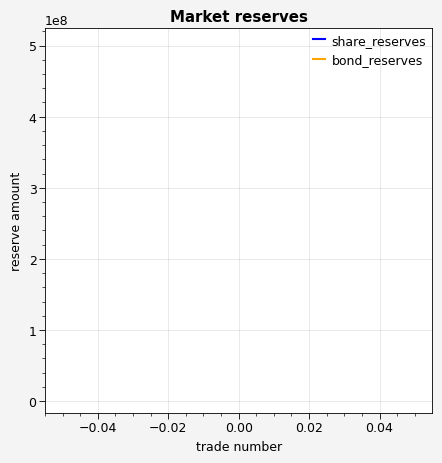

In [18]:
fig, axes, _ = output_utils.get_gridspec_subplots(nrows=1, ncols=1)
ax = trades.iloc[:-1].plot(x="trade_number", y="share_reserves", ax=axes[0], c="blue")
ax = trades.iloc[:-1].plot(x="trade_number", y="bond_reserves", ax=axes[0], c="orange")
ax.set_xlabel("trade number")
ax.set_ylabel("reserve amount")
ax.set_title("Market reserves")
fig.set_size_inches(fig_size)